# Классификация древних языков с помощью Alexnet

In [ ]:
import os
#import numpy as np
from google.colab import files
from fastai import *
from fastai.vision import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Загрузка файлов

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving ancient.zip to ancient.zip


In [ ]:
!unzip ancient.zip

Archive:  ancient.zip
  inflating: ancient_language_dataset/test/arabic/24dca116894a4de7e530f7f7ffdf5cea--islamic-images-arabic-beauty.jpg  
  inflating: ancient_language_dataset/test/arabic/Calligraphy-Arabic-Font161-min.jpg  
  inflating: ancient_language_dataset/test/arabic/Khirbet-Inscription-Hisham.jpg  
  inflating: ancient_language_dataset/test/arabic/MalDia-04-10-08-16-Abate-Vella-claimed-to-have-discovered-ancient-Arabic-parchments.-751x1024.jpg  
  inflating: ancient_language_dataset/test/arabic/Writing-style-follow-by-Arabic-Script_Q320.jpg  
  inflating: ancient_language_dataset/test/arabic/a31224b.jpg  
  inflating: ancient_language_dataset/test/arabic/epigraphy_ambalangoda_port_des_01.jpg  
  inflating: ancient_language_dataset/test/arabic/istockphoto-183578917-612x612.jpg  
  inflating: ancient_language_dataset/test/arabic/istockphoto-644911038-1024x1024.jpg  
  inflating: ancient_language_dataset/test/egyptian/124388-004-686BFFFF.jpg  
  inflating: ancient_language_data

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4 MB 6.7 kB/s 
     |████████████████████████████████| 4.0 MB 58.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


### Обучение нейросети

In [ ]:
bs=16
np.random.seed(2)
os.chdir('/content')

In [ ]:
data_path = "./ancient_language_dataset/"
data = ImageDataBunch.from_folder(data_path, ds_tfms=get_transforms(), size=299, bs=bs, num_workers=0).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.alexnet, metrics=accuracy, path=".")

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 74, 74]         23,296     False     
______________________________________________________________________
ReLU                 [64, 74, 74]         0          False     
______________________________________________________________________
MaxPool2d            [64, 36, 36]         0          False     
______________________________________________________________________
Conv2d               [192, 36, 36]        307,392    False     
______________________________________________________________________
ReLU                 [192, 36, 36]        0          False     
______________________________________________________________________
MaxPool2d            [192, 17, 17]        0          False     
______________________________________________________________________
Conv2d               [384, 17, 17]        663,936    False     
___________________________________________________

In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,3.448733,2.294237,0.200000,00:09
1,3.090903,1.623111,0.384615,00:09
2,2.719454,1.282321,0.569231,00:09
3,2.262476,1.199598,0.615385,00:09
4,1.997207,1.265558,0.553846,00:09
5,1.777130,1.138364,0.615385,00:09
6,1.552640,1.224059,0.630769,00:09
7,1.340949,1.488666,0.569231,00:09
8,1.297836,1.266804,0.630769,00:09
9,1.166758,1.114588,0.600000,00:09


In [ ]:
learn.save('stage-1')

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


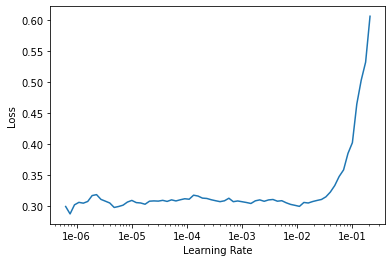

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.552909,1.174633,0.661538,00:09
1,0.514365,1.142533,0.661538,00:09
2,0.491867,1.257326,0.630769,00:09
3,0.458170,1.259500,0.646154,00:10
4,0.472040,1.261849,0.646154,00:09
5,0.436347,1.204639,0.646154,00:09
6,0.451679,1.169709,0.661538,00:09
7,0.443170,1.155567,0.676923,00:09
8,0.440712,1.144427,0.661538,00:09
9,0.421382,1.153359,0.692308,00:10


In [ ]:
learn.save('stage-2')

In [ ]:
learn.fit_one_cycle(3,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.433243,1.156193,0.676923,00:09
1,0.425736,1.130825,0.661538,00:09
2,0.380976,1.100848,0.692308,00:09


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs=interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

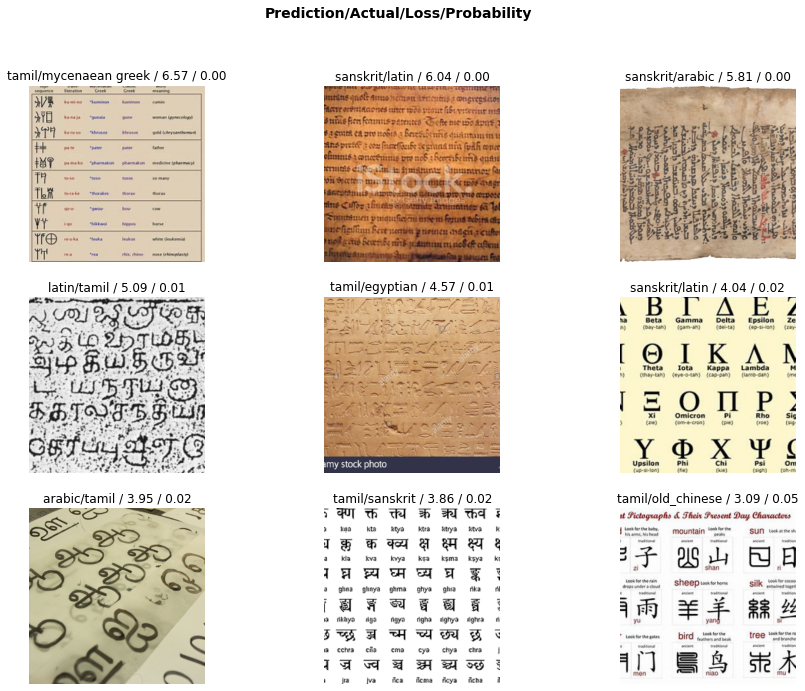

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

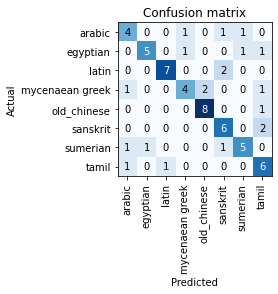

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=1)

[('latin', 'sanskrit', 2),
 ('mycenaean greek', 'old_chinese', 2),
 ('sanskrit', 'tamil', 2),
 ('arabic', 'mycenaean greek', 1),
 ('arabic', 'sanskrit', 1),
 ('arabic', 'sumerian', 1),
 ('egyptian', 'mycenaean greek', 1),
 ('egyptian', 'sumerian', 1),
 ('egyptian', 'tamil', 1),
 ('mycenaean greek', 'arabic', 1),
 ('mycenaean greek', 'tamil', 1),
 ('old_chinese', 'tamil', 1),
 ('sumerian', 'arabic', 1),
 ('sumerian', 'egyptian', 1),
 ('sumerian', 'sanskrit', 1),
 ('tamil', 'arabic', 1),
 ('tamil', 'latin', 1)]

In [ ]:
precision = 0
recall = 0
for i in range(0, 7):
  s = 0
  for j in range(0, 7):
    s += interp.confusion_matrix()[i][j]
  precision_i = interp.confusion_matrix()[i][i] / s
  precision += precision_i
  s = 0
  for j in range(0, 7):
    s += interp.confusion_matrix()[j][i]
  recall_i = interp.confusion_matrix()[i][i] / s
  recall += recall_i

precision = precision / 8
recall = recall / 8
print(precision, recall)

0.6574900793650793 0.6601190476190476


In [ ]:
f1score = 2 * (precision * recall) / (precision + recall)
f1score

0.6588019407589863

In [ ]:
num = 0
denom = 0
for i in range(0, 7):
  num += interp.confusion_matrix()[i][i]
  for j in range(0, 7):
    denom += interp.confusion_matrix()[i][j]

acc = num / denom
acc

0.75